In [1]:
# !pip install -q git+https://github.com/RobertJaro/NF2.git

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LambdaCallback

from nf2.train.module import NF2Module, save
from nf2.evaluation.unpack import load_cube

from utils.data_load import load_nc
from utils.data_loader import ArrayDataModule
from utils.metric import evaluate
from utils.plotting import plot_overview, plot_sample
from utils.validation import valid

/userhome/jeon_mg/miniforge3/envs/nf2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
base_path = '/mnt/userdata/jeon_mg/spinn/pinn/'
os.makedirs(base_path, exist_ok=True)
save_path = os.path.join(base_path, 'extrapolation_result.nf2')

data_args = {
                "bin": 1,
                "height_mapping": {"z":  [0.0]},
                "Mm_per_pixel": 1,
                "boundary": {"type":  "potential", "strides":  4},
                "height": 257,
                "b_norm": 2500,
                "spatial_norm": 320,
                "batch_size": {"boundary":  1e4, "random":  2e4},
                "iterations": 10000,
                "work_directory": "/userhome/jeon_mg/workspace/tmp/isee_11158_257",
                "num_workers": 8
             }

model_args = {
                "dim": 256, 
                "use_vector_potential": False
             }

training_args = {
                    "max_epochs": 1,
                    "lambda_b": {"start": 1e3, "end": 1, "iterations" : 5e4},
                    "lambda_div": 1e-1,
                    "lambda_ff": 1e-1,
                    "lambda_height_reg": 1e-3,
                    "validation_interval": 10000,
                    "lr_params": {"start": 5e-4, "end": 5e-5, "decay_iterations": 1e5}
                }

config = {'data': data_args, 'model': model_args, 'training': training_args}

In [4]:
b_true = load_nc('/mnt/obsdata/isee_nlfff_v1.2/11158/11158_20110213_120000.nc')

b_bottom = b_true[:, :, 0, :][:, :, None, :]
b_true.shape, b_bottom.shape

((513, 257, 257, 3), (513, 257, 1, 3))

In [5]:
wandb_logger = WandbLogger(project="nf2", name="11158_20110213_120000", offline=False, 
                           entity="mgjeon", id=None, dir=base_path, log_model="all")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mgjeon. Use `wandb login --relogin` to force relogin


In [6]:
data_module = ArrayDataModule(b_bottom, **data_args)

In [7]:
validation_settings = {'cube_shape': data_module.cube_dataset.coords_shape,
                       'gauss_per_dB': data_args['b_norm'],
                       'Mm_per_ds': data_module.Mm_per_pixel * data_args['spatial_norm']}

nf2 = NF2Module(validation_settings, **model_args, **training_args)

In [8]:
save_callback = LambdaCallback(on_validation_end=lambda *args: 
                              save(save_path, nf2.model, data_module, config, nf2.height_mapping_model))
checkpoint_callback = ModelCheckpoint(dirpath=base_path,
                                      every_n_train_steps=training_args['validation_interval'],
                                      save_last=True)

In [9]:
n_gpus = torch.cuda.device_count()
trainer = Trainer(max_epochs=1,
                  logger=wandb_logger,
                  devices=n_gpus if n_gpus >= 1 else None,
                  accelerator='gpu' if n_gpus >= 1 else None,
                  strategy='dp' if n_gpus > 1 else None,
                  num_sanity_val_steps=0,
                  val_check_interval=training_args['validation_interval'],
                  gradient_clip_val=0.1,
                  callbacks=[checkpoint_callback, save_callback], )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [10]:
start = time.time()

trainer.fit(nf2, data_module, ckpt_path='last')

runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec')

/userhome/jeon_mg/miniforge3/envs/nf2/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /mnt/userdata/jeon_mg/spinn/pinn/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /mnt/userdata/jeon_mg/spinn/pinn/last.ckpt


/userhome/jeon_mg/miniforge3/envs/nf2/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1452: UserWarning: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': None, 'mode': 'min', 'every_n_train_steps': 1, 'every_n_epochs': 0, 'train_time_interval': None}"].
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | BModel | 528 K 
---------------------------------
528 K     Trainable params
0         Non-trainable params
528 K     Total params
2.113     Total estimated model params size (MB)
Restored all states from the checkpoint file at /mnt/userdata/jeon_mg/spinn/pinn/last.ckpt
/userhome/jeon_mg/miniforge3/envs/nf2/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (10) is smalle

Epoch 0:   0%|          | 0/3416 [00:00<?, ?it/s]             

/userhome/jeon_mg/miniforge3/envs/nf2/lib/python3.10/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:142: UserWarning: You're resuming from a checkpoint that ended before the epoch ended. This can cause unreliable results if further training is done. Consider using an end-of-epoch checkpoint or enabling fault-tolerant training: https://pytorch-lightning.readthedocs.io/en/stable/advanced/fault_tolerant_training.html
  rank_zero_warn(


Epoch 0: : 6822it [02:04, 54.74it/s, loss=11.4, v_num=j21b]                        

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: : 6822it [02:04, 54.74it/s, loss=11.4, v_num=j21b]


In [11]:
save(save_path, nf2.model, data_module, config, nf2.height_mapping_model)

In [12]:
b = load_cube(save_path, progress=True)

100%|██████████| 33884/33884 [00:36<00:00, 916.96it/s]


In [13]:
evaluate(b, b_true)

/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:79: RuntimeWarning: invalid value encountered in divide
  result['c_cs'] = 1 / M * np.sum((B * b).sum(-1) / vector_norm(B) / vector_norm(b))
/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:88: RuntimeWarning: divide by zero encountered in divide
  result['E_m'] = 1 / M * (vector_norm(b - B) / vector_norm(B)).sum()
/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:99: RuntimeWarning: invalid value encountered in divide
  result['sig_J_ll'] = (vector_norm(np.cross(J, B, -1)) / vector_norm(B)).sum() / (vector_norm(J).sum() + 1e-6) * 1e2
/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:104: RuntimeWarning: invalid value encountered in divide
  result['L1_B'] = (vector_norm(np.cross(curl(B), B, -1)) ** 2 / vector_norm(B) ** 2).mean()


{'c_vec': 0.06478155124536762,
 'c_vec_2': 0.06478155124536762,
 'c_cs': nan,
 'c_cs_2': 0.1029877903043216,
 'c_cs_2_ep': 0.10298779027699358,
 'E_n': 2.0457236323877197,
 'E_n_2': 2.0457236323877197,
 'E_m': inf,
 'E_m_2': 5.788607495752989,
 'E_m_ep': 1169582.8419365396,
 'eps': 0.31002599987915586,
 'sig_J': 98.35394193969154,
 'sig_J_ll': nan,
 'L1': 0.0044180835,
 'L2': 0.00051940855,
 'L1_B': nan,
 'L2_B': 10.718387826633455,
 'L2n': 0.08704829961061478,
 'L2n_B': 129488124.65404812,
 'relative_l2': 1.1126030297138942,
 'mse': 1026.0628131536946}

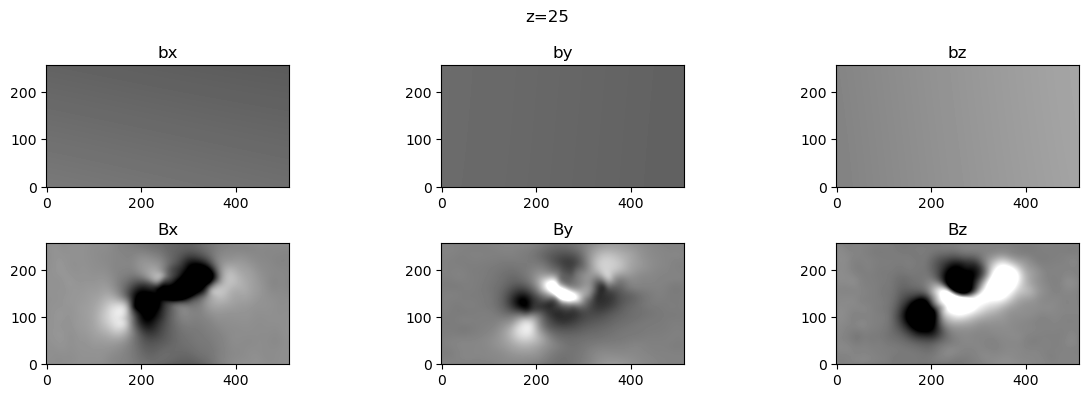

In [14]:
plot_overview(b, b_true, z=25, b_norm=100)

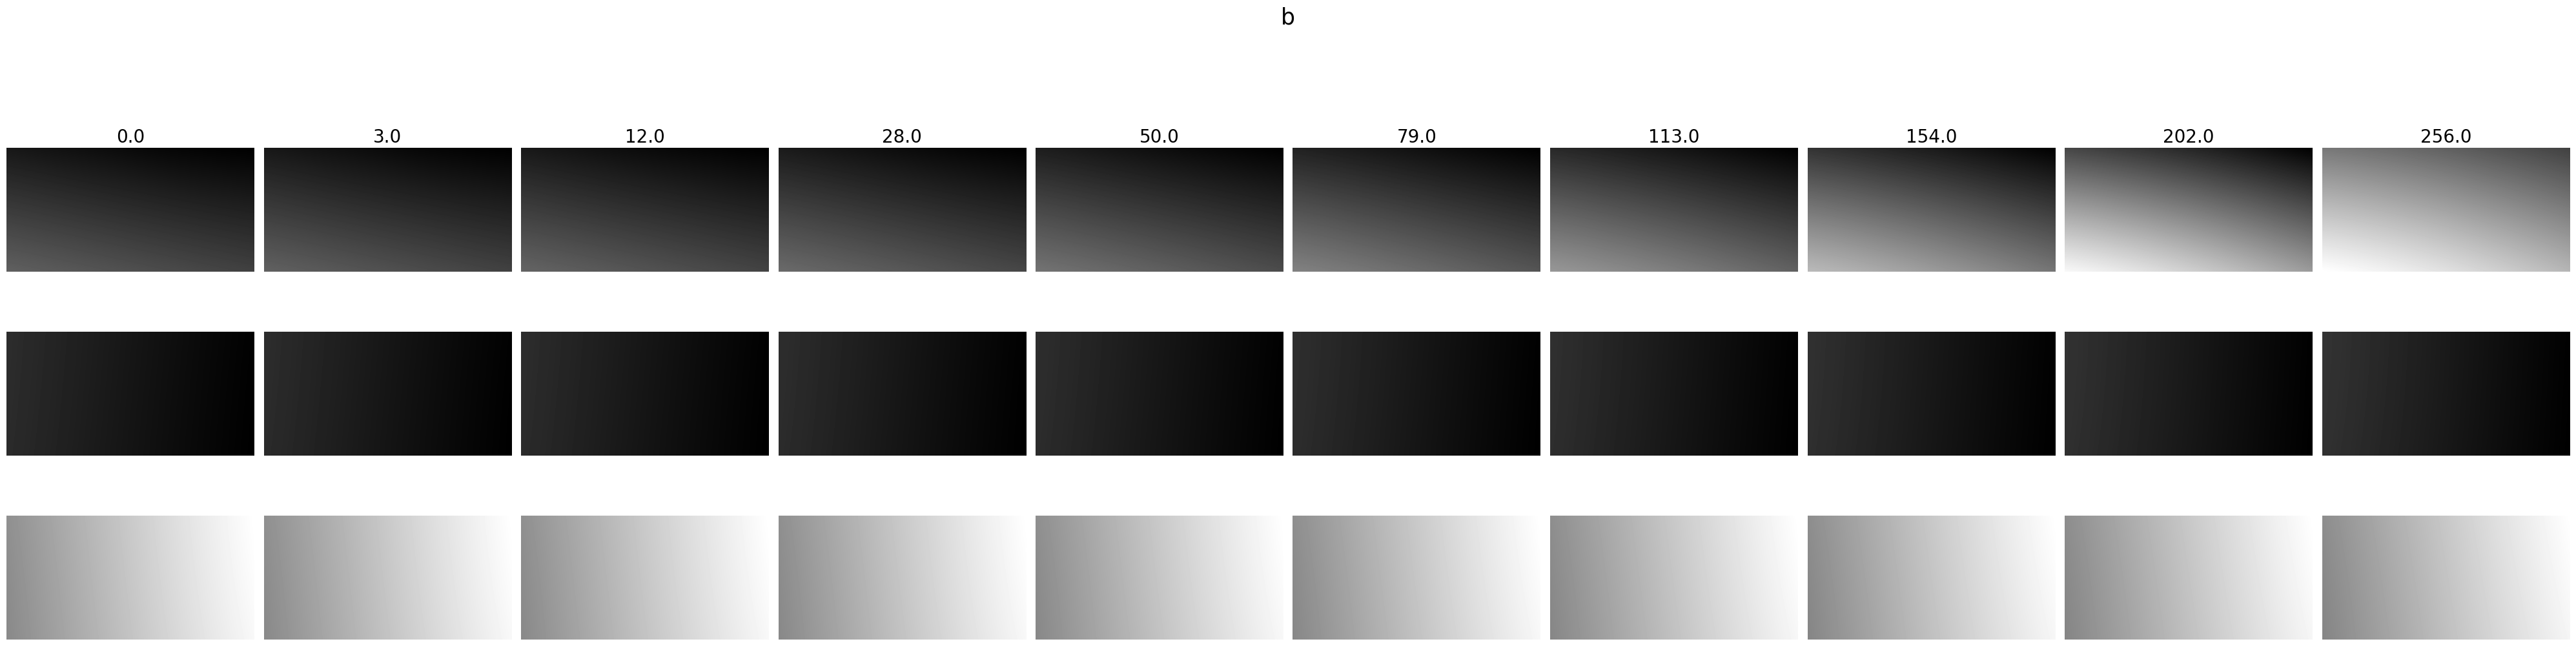

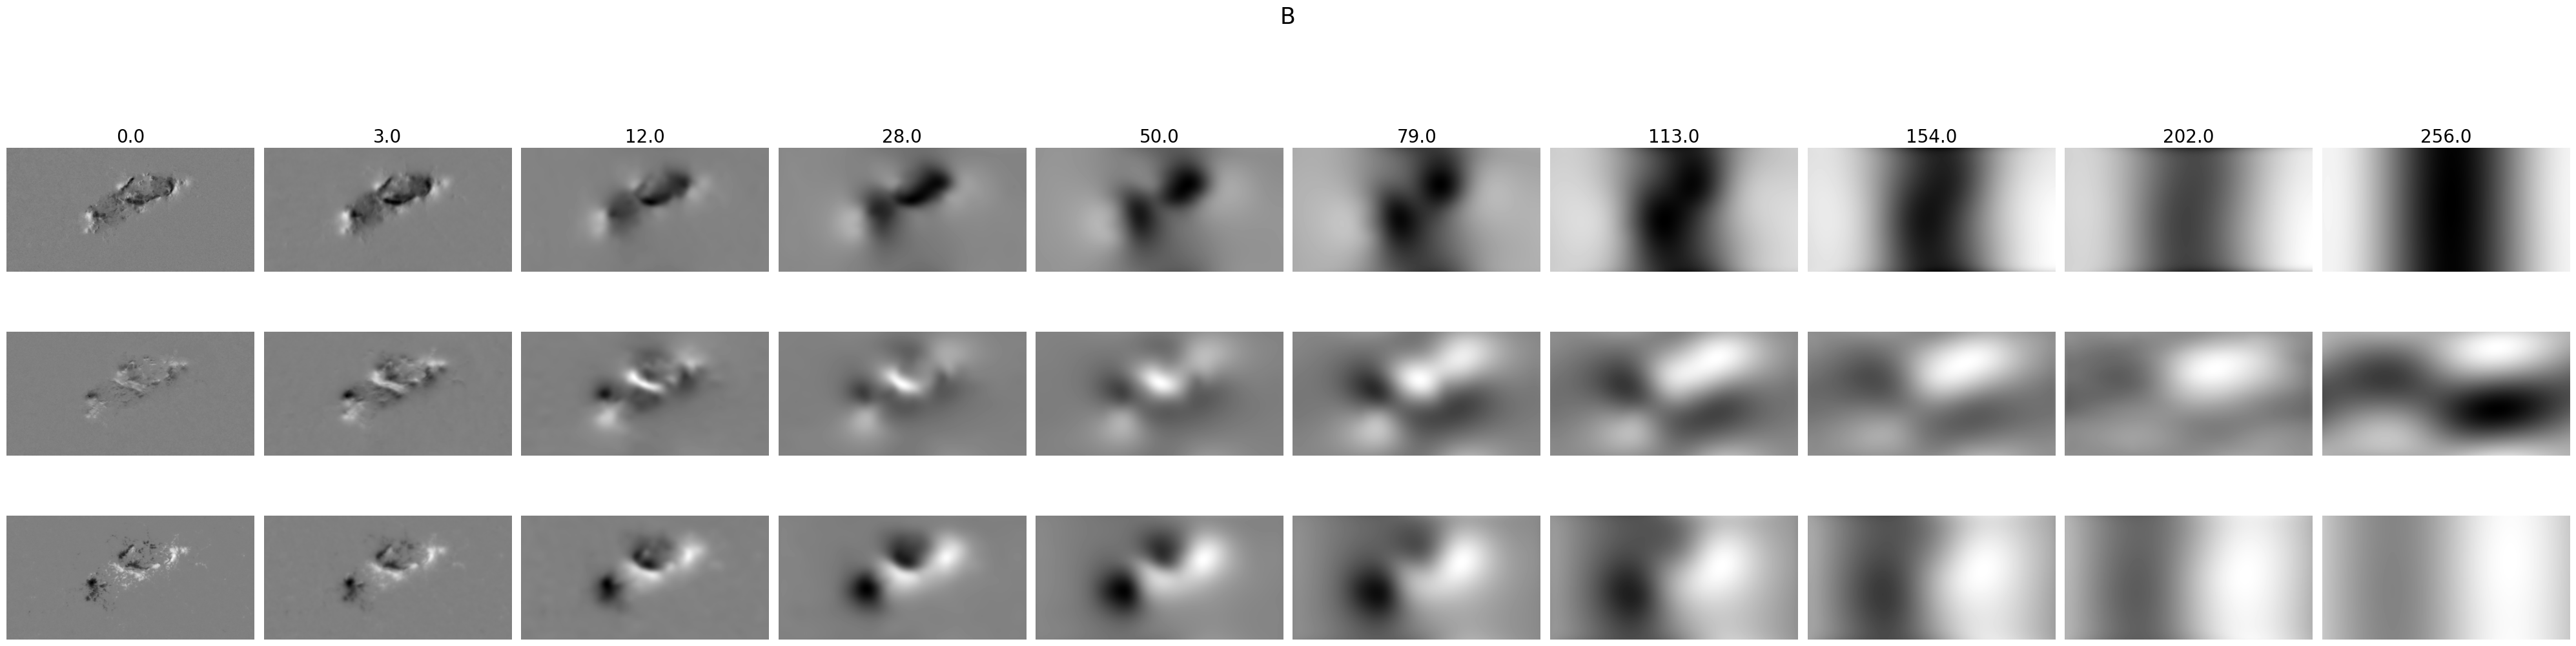

In [15]:
plot_sample(b, b_true)

Both the divergence and the angle between the currents and magnetic field should be small.
(ideally mean divergence `<0.1` and sigma `<10` degree; the exact values depend on the selected active region and lambda weights)

sig_J * 1e2: 98.3539; Lf: 0.0044; Ld: 0.0005
DIVERGENCE [1/pix]: 0.0009; THETA [deg] 79.5898


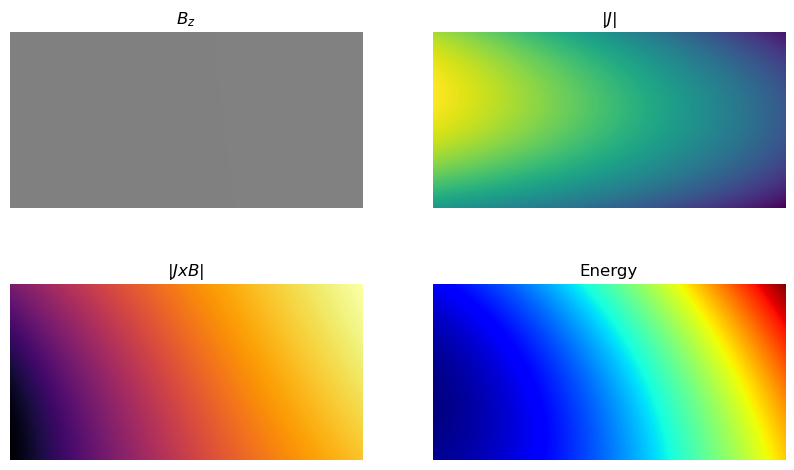

In [16]:
valid(b)

/userhome/jeon_mg/workspace/2023_007_zpinn/example/notebooks/utils/metric.py:44: RuntimeWarning: invalid value encountered in divide
  sigma = vector_norm(lorentz_force(b, j)) / vector_norm(b) / vector_norm(j)


Both the divergence and the angle between the currents and magnetic field should be small.
(ideally mean divergence `<0.1` and sigma `<10` degree; the exact values depend on the selected active region and lambda weights)

sig_J * 1e2: 72.0747; Lf: 57.5472; Ld: 10.7184
DIVERGENCE [1/pix]: 129488.1276; THETA [deg] nan


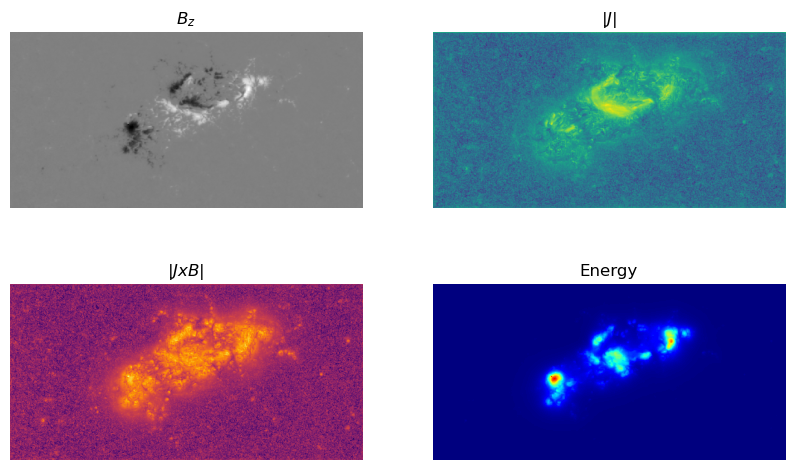

In [17]:
# valid(b_true)